In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens-20m-dataset/rating.csv
/kaggle/input/movielens-20m-dataset/link.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv
/kaggle/input/movielens-20m-dataset/tag.csv
/kaggle/input/movielens-20m-dataset/movie.csv


1️⃣ Kütüphaneler

In [2]:
# -----------------------------
# 1️⃣ Kütüphaneler
# -----------------------------
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')


Dataset Yükleme ve İlk Kontroller

In [3]:
# Kaggle'daki dosyaları listele
os.listdir('/kaggle/input/movielens-20m-dataset')

# Veri setlerini oku
ratings = pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')
movies = pd.read_csv('/kaggle/input/movielens-20m-dataset/movie.csv')

# İlk 5 satırı kontrol
print("Ratings ilk 5 satır:\n", ratings.head())
print("\nMovies ilk 5 satır:\n", movies.head())


Ratings ilk 5 satır:
    userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40

Movies ilk 5 satır:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


Ratings veri seti (ilk 5 satır):
    userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40

Movies veri seti (ilk 5 satır):
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
Kullanıcı sayısı: 138493
Film sayısı: 26744


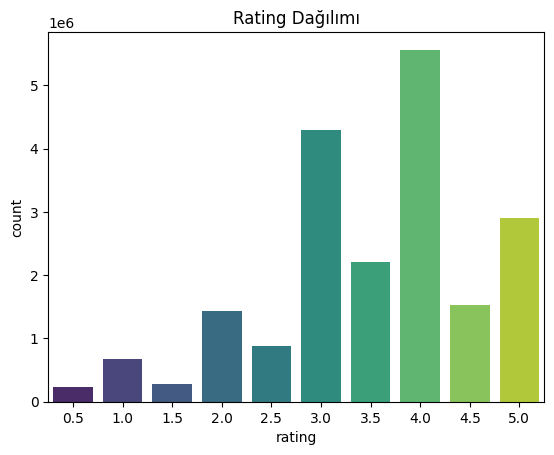

In [4]:
# İlk 5 satır
print("Ratings veri seti (ilk 5 satır):\n", ratings.head())
print("\nMovies veri seti (ilk 5 satır):\n", movies.head())

# Kaç kullanıcı ve film var?
print(f"Kullanıcı sayısı: {ratings['userId'].nunique()}")
print(f"Film sayısı: {ratings['movieId'].nunique()}")

# Rating dağılımı
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title("Rating Dağılımı")
plt.show()


Liked Filtreleme ve Popüler Filmler

In [5]:
# Ratings ve Movies merge
ratings_movies = pd.merge(ratings, movies, on="movieId")

# Rating >=4 olanlar liked olarak işaretlendi
liked = ratings_movies[ratings_movies['rating'] >= 4].copy()

# En az 50 kez liked alan filmler
popular_movies = liked['movieId'].value_counts()[lambda x: x >= 50].index
liked = liked[liked['movieId'].isin(popular_movies)]

print(f"Filtre sonrası kullanıcı sayısı: {liked['userId'].nunique()}")
print(f"Filtre sonrası film sayısı: {liked['movieId'].nunique()}")


Filtre sonrası kullanıcı sayısı: 138287
Filtre sonrası film sayısı: 7345


One-Hot Matrisi Oluşturma

In [6]:
basket = liked.assign(val=1).pivot_table(
    index='userId', columns='movieId', values='val', aggfunc='max', fill_value=0
)

print("One-hot matrisi boyutu:", basket.shape)
basket.head()


One-hot matrisi boyutu: (138287, 7345)


movieId,1,2,3,4,5,6,7,8,9,10,...,115617,116161,116797,116823,117176,117533,118696,118900,119141,119145
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Küçük Subset Görselleştirme (Isıl Harita)

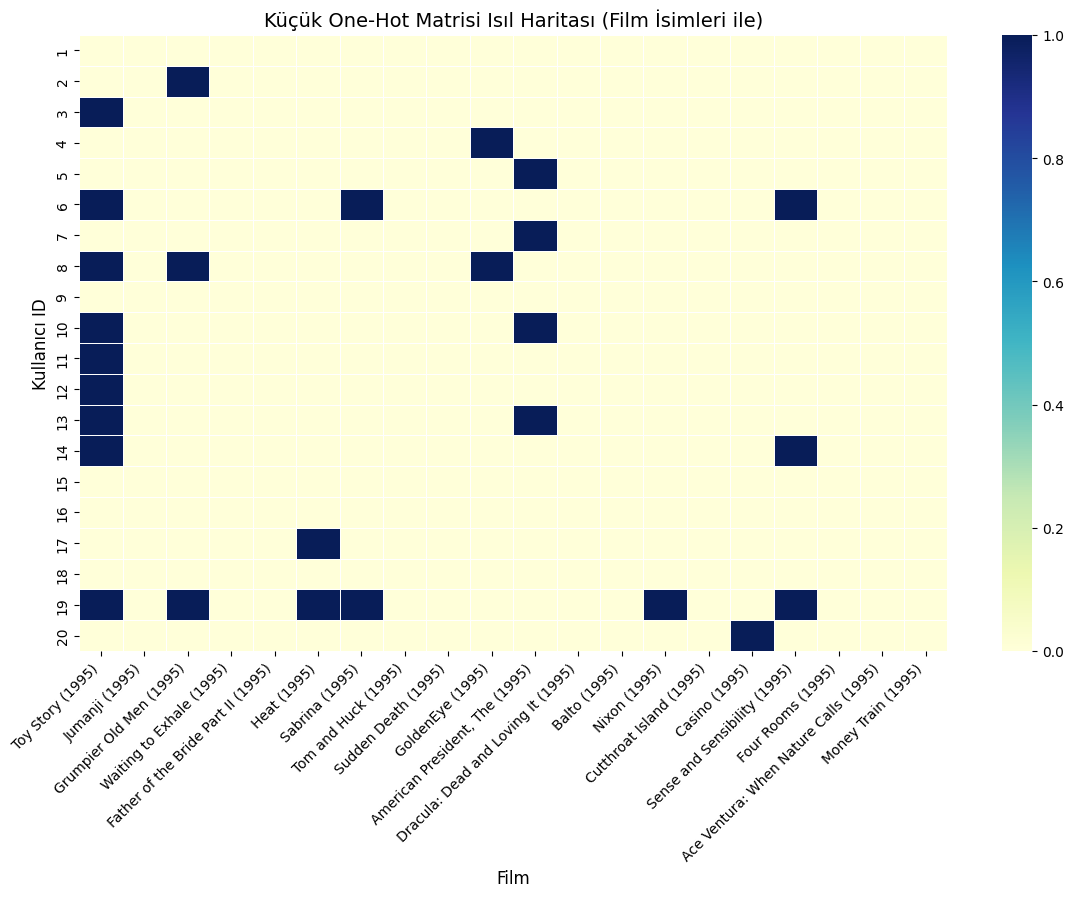

In [7]:
subset_basket = basket.iloc[:20, :20]  # hızlı test için küçük subset
movie_id_to_title = dict(zip(movies['movieId'], movies['title']))
subset_basket_named = subset_basket.rename(columns=movie_id_to_title)

plt.figure(figsize=(14,8))
sns.heatmap(subset_basket_named, cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("Küçük One-Hot Matrisi Isıl Haritası (Film İsimleri ile)", fontsize=14)
plt.xlabel("Film", fontsize=12)
plt.ylabel("Kullanıcı ID", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()


Apriori ve Association Rules (Küçük Subset)

In [8]:
subset_basket = basket.iloc[:500, :100]  # Hızlı test için

# Sık itemset çıkar
frequent_itemsets = apriori(subset_basket, min_support=0.01, use_colnames=True)

# Association rules oluştur
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.25)
rules = rules[rules['lift'] > 1].sort_values(['confidence','lift'], ascending=False)

print("Top 5 Apriori kuralı:\n")
print(rules.head())


Top 5 Apriori kuralı:

       antecedents   consequents  antecedent support  consequent support  \
2472          (89)  (50, 11, 47)                0.01               0.018   
3739  (21, 36, 45)      (25, 11)                0.01               0.020   
3743  (25, 11, 45)      (36, 21)                0.01               0.024   
3736  (11, 36, 45)      (25, 21)                0.01               0.028   
3740  (25, 36, 45)      (11, 21)                0.01               0.032   

      support  confidence       lift  representativity  leverage  conviction  \
2472     0.01         1.0  55.555556               1.0   0.00982         inf   
3739     0.01         1.0  50.000000               1.0   0.00980         inf   
3743     0.01         1.0  41.666667               1.0   0.00976         inf   
3736     0.01         1.0  35.714286               1.0   0.00972         inf   
3740     0.01         1.0  31.250000               1.0   0.00968         inf   

      zhangs_metric   jaccard  certaint

Öneri Fonksiyonu (Film İsimleriyle)

In [9]:
def recommend_movie_names(rules_df, movie_id, movies_df, top_n=5):
    suggestions = rules_df[rules_df['antecedents'].apply(lambda x: movie_id in x)]['consequents']
    recommended_ids = set()
    for item in suggestions:
        recommended_ids.update(item)
    recommended_ids.discard(movie_id)
    recommended_ids = list(recommended_ids)[:top_n]
    recommended_titles = movies_df[movies_df['movieId'].isin(recommended_ids)]['title'].tolist()
    return recommended_titles


Örnek Öneri

In [10]:
sample_movie_id = subset_basket.columns[0]  # ilk film ID
movie_title = movies[movies['movieId'] == sample_movie_id]['title'].values[0]

print(f"Kullanıcı '{movie_title}' filmini izlediyse, önerilen filmler:")
print(recommend_movie_names(rules, sample_movie_id, movies, top_n=5))


Kullanıcı 'Toy Story (1995)' filmini izlediyse, önerilen filmler:
['Heat (1995)', 'Sabrina (1995)', 'GoldenEye (1995)', 'Friday (1995)', 'From Dusk Till Dawn (1996)']


Bir sonraki adımda bunu yapabiliriz:

Top kuralları (örn. confidence ve lift’e göre sıralanmış ilk 20-50 kural) alacağız,

Network grafiği oluşturacağız: daireler filmleri, oklar kuralları gösterecek,

Daire boyutları veya renkleri ile support, ok kalınlığı veya renkleri ile confidence/lift değerlerini görselleştireceğiz.

Böylece Apriori kurallarını hem okunabilir hem de görselleştirilmiş bir şekilde sunabiliriz.

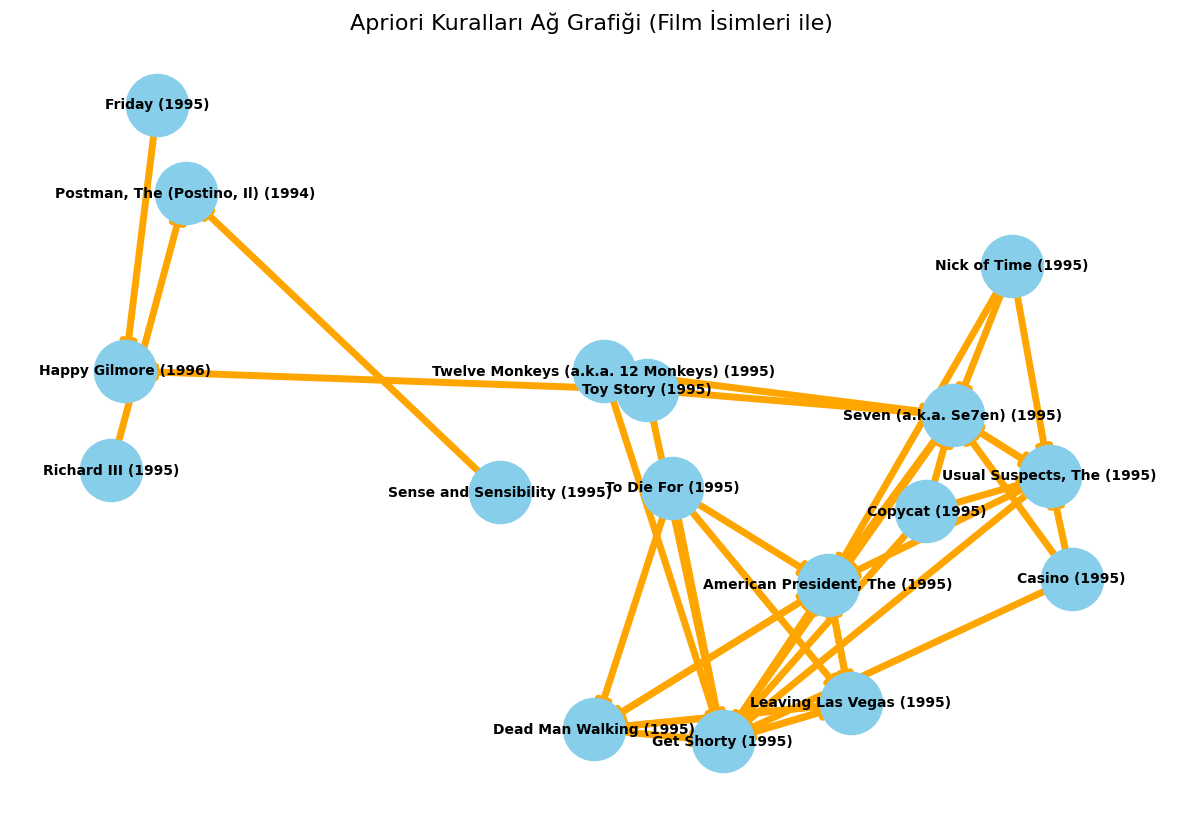

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Top 20 kuralı al
top_rules = rules.sort_values(['confidence','lift'], ascending=False).head(20)

G = nx.DiGraph()
for _, row in top_rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(movie_id_to_title[a], movie_id_to_title[c], weight=row['confidence'])

plt.figure(figsize=(15,10))
pos = nx.spring_layout(G, k=1)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

edges = G.edges(data=True)
nx.draw_networkx_edges(
    G, pos, edgelist=edges,
    arrowstyle='-|>', arrowsize=20,
    width=[d['weight']*5 for (_,_,d) in edges],
    edge_color='orange'
)

plt.title("Apriori Kuralları Ağ Grafiği (Film İsimleri ile)", fontsize=16)
plt.axis('off')
plt.show()


bunu top 50 kuralla daha detaylı ve okunaklı hâle getireyim

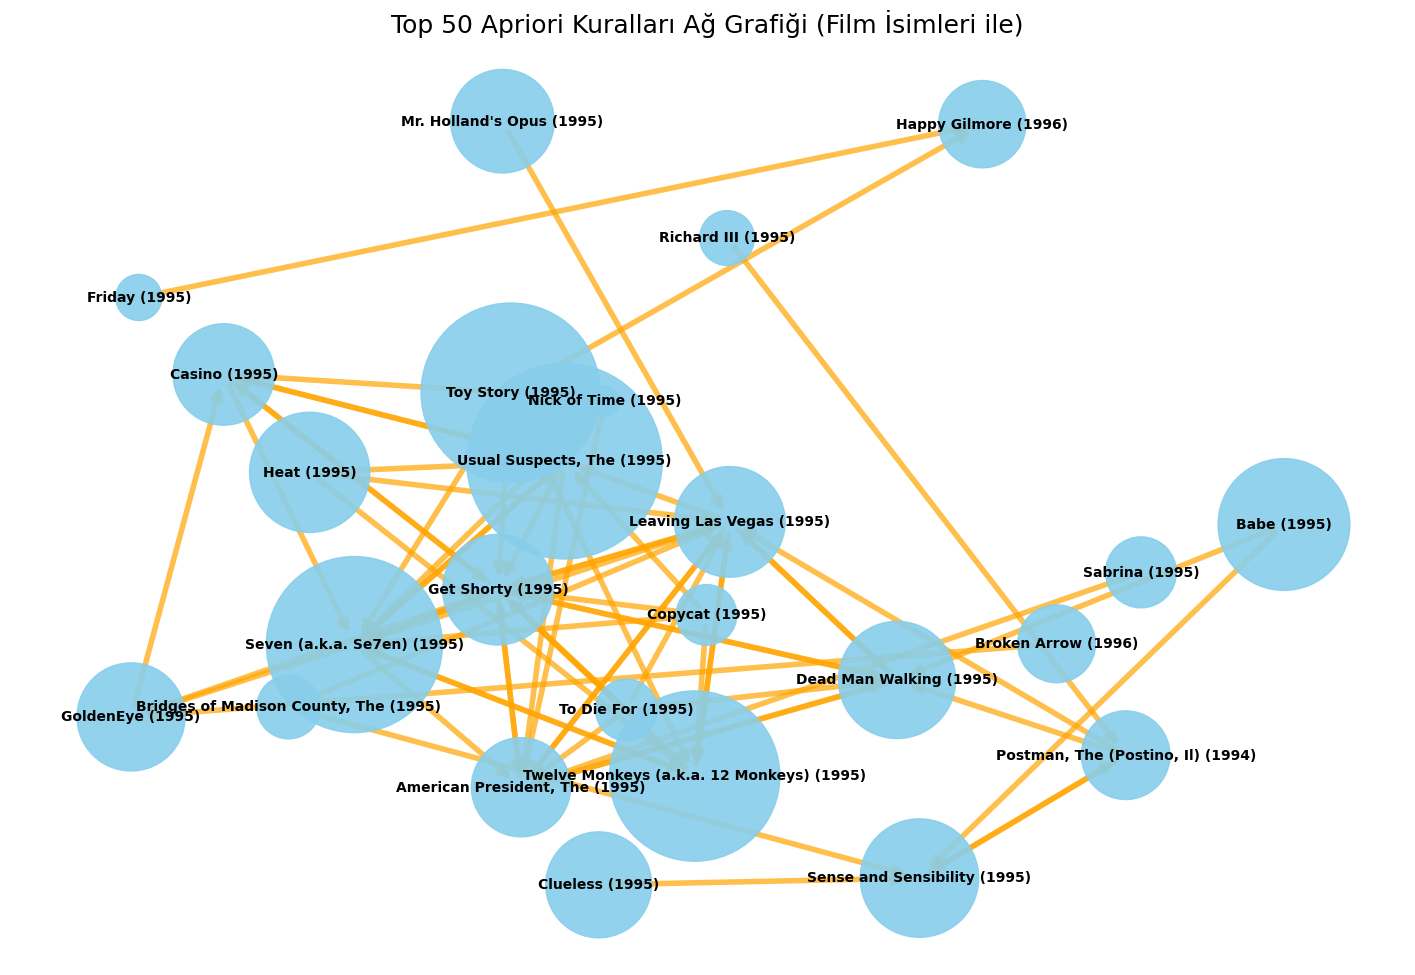

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# Top 50 kuralı al
top_rules = rules.sort_values(['confidence','lift'], ascending=False).head(50)

# Node boyutu için film support değerlerini al
support_dict = {movie_id_to_title[i]: basket[i].sum() for i in basket.columns if i in movie_id_to_title}

# Network grafiği oluştur
G = nx.DiGraph()

for _, row in top_rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(movie_id_to_title[a], movie_id_to_title[c], weight=row['confidence'])

plt.figure(figsize=(18,12))
pos = nx.spring_layout(G, k=1, seed=42)  # seed ile layout sabitlenebilir

# Düğümler ve node boyutları support ile
node_sizes = [support_dict.get(node, 50) * 0.5 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Oklar ve kalınlıkları confidence ile
edges = G.edges(data=True)
nx.draw_networkx_edges(
    G, pos, edgelist=edges,
    arrowstyle='-|>', arrowsize=15,
    width=[d['weight']*4 for (_,_,d) in edges],
    edge_color='orange', alpha=0.7
)

plt.title("Top 50 Apriori Kuralları Ağ Grafiği (Film İsimleri ile)", fontsize=18)
plt.axis('off')
plt.show()


eksik veri var mı hızlıca gözden geçirdim:

In [13]:
# Ratings veri seti
print("Ratings veri setindeki eksik değerler:")
print(ratings.isnull().sum())

# Movies veri seti
print("\nMovies veri setindeki eksik değerler:")
print(movies.isnull().sum())

# Birleştirilmiş veri seti (ratings + movies)
ratings_movies = pd.merge(ratings, movies, on="movieId")
print("\nBirleştirilmiş veri setindeki eksik değerler:")
print(ratings_movies.isnull().sum())


Ratings veri setindeki eksik değerler:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Movies veri setindeki eksik değerler:
movieId    0
title      0
genres     0
dtype: int64

Birleştirilmiş veri setindeki eksik değerler:
userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64


Şu ana kadar:

Dataset okundu ve birleştirildi (ratings + movies).

Eksik veri kontrolü yapıldı (sorun yok).

Liked filtrelemesi ve popüler film filtrelemesi uygulandı.

One-hot matrisi oluşturuldu (basket).

Küçük subset ile Apriori testi yapıldı ve top kurallar incelendi.

Network grafiği ile kuralların görselleştirmesi tamamlandı.

Interaktif network grafiği hazırlandı (Plotly).

Adım 1: Collaborative Filtering için kullanıcı-film pivot tablosu

Apriori kısmı zaten kurallara dayalı öneri sağlıyor. Şimdi CF için kullanıcı-film matrisini oluşturalım:


**MovieLens 20M dataset’inde:~138.000 kullanıcı~27.000 film→ Pivot tablosu 138k × 27k hücre oluşturacak, bu hafıza ve performans problemi yaratır.Bunu çözmek için küçük bir subset ile test yapabiliriz:**


In [14]:
import pandas as pd

# Dosyaları oku
ratings = pd.read_csv("/kaggle/input/movielens-20m-dataset/rating.csv")
movies = pd.read_csv("/kaggle/input/movielens-20m-dataset/movie.csv")

# Birleştir
ratings_movies = pd.merge(ratings, movies, on="movieId")

# İlk 5 satıra göz atalım
ratings_movies.head()


,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


2️⃣ Subset ile pivot tablosu oluştur

In [15]:
# Örnek subset: ilk 1000 kullanıcı ve en popüler 500 film
popular_movies = ratings_movies['movieId'].value_counts().head(500).index
subset = ratings_movies[ratings_movies['movieId'].isin(popular_movies)]
subset = subset[subset['userId'] <= 1000]

# Pivot tablosu
user_movie_matrix = subset.pivot_table(
    index='userId',
    columns='movieId',
    values='rating',
    fill_value=0
)

print("Subset pivot tablosu boyutu:", user_movie_matrix.shape)
user_movie_matrix.head()


Subset pivot tablosu boyutu: (991, 500)


movieId,1,2,3,5,6,7,10,11,16,17,...,54286,55820,56367,58559,59315,60069,68157,68954,72998,79132
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Apriori ile çıkarılan kuralları ağ grafiği şeklinde görselleştirebiliriz:

Düğümler (nodes) → Filmler

Oklar / kenarlar (edges) → Kuralları temsil eder (X → Y)

Düğüm büyüklüğü → popülerlik (kaç kez geçtiği)

Kenar kalınlığı → kuralın lift değeri

One-hot pivot tablosu için küçük subset oluştur

In [16]:
# En popüler 20 film
popular_movies = ratings_movies['movieId'].value_counts().head(20).index

# İlk 20 kullanıcı
subset = ratings_movies[ratings_movies['movieId'].isin(popular_movies)]
subset = subset[subset['userId'] <= 20]

# Kullanıcı × Film pivot tablosu (rating >=4 ise 1, değilse 0)
subset_small = subset.pivot_table(
    index='userId',
    columns='movieId',
    values='rating',
    fill_value=0
).apply(lambda col: col.map(lambda x: 1 if x >= 4 else 0))


O zaman Apriori kurallarına dayalı öneri fonksiyonunu yazalım ve örnek gösterelim.

In [17]:
#Öneri Fonksiyonu (Film ID → Film İsmi ile)
def recommend_movies(rules_df, movie_id, movies_df, top_n=5):
    """
    Kurallara dayalı öneri fonksiyonu.
    rules_df: Apriori ile elde edilen kurallar
    movie_id: Kullanıcının izlediği film ID
    movies_df: movieId -> title mapping için
    top_n: Önerilecek film sayısı
    """
    # Kuralların antecedent kısmında movie_id olanları seç
    recs = rules_df[rules_df['antecedents'].apply(lambda x: movie_id in x)]
    
    # confidence ve lift’e göre sırala
    recs = recs.sort_values(['confidence', 'lift'], ascending=False)
    
    # En çok önerilen filmID’lerini al
    recommended_ids = []
    for consequents in recs['consequents']:
        recommended_ids.extend(list(consequents))
    
    # Film ID’lerini isimlere çevir ve tekrar edenleri kaldır
    recommended_titles = [movies_df[movies_df['movieId']==mid]['title'].values[0] 
                          for mid in recommended_ids if mid != movie_id]
    
    # Tekrarlardan temizle ve top_n al
    return recommended_titles[:top_n]


Örnek Kullanım

In [18]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Küçük subset (ilk 20 kullanıcı ve 20 popüler film)
popular_movies = ratings_movies['movieId'].value_counts().head(20).index
subset = ratings_movies[ratings_movies['movieId'].isin(popular_movies)]
subset = subset[subset['userId'] <= 20]

subset_small = subset.pivot_table(
    index='userId',
    columns='movieId',
    values='rating',
    fill_value=0
).apply(lambda col: col.map(lambda x: 1 if x >= 4 else 0))

# Apriori
frequent_itemsets = apriori(subset_small, min_support=0.2, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Öneri fonksiyonu
def recommend_movies(rules_df, movie_id, movies_df, top_n=5):
    recs = rules_df[rules_df['antecedents'].apply(lambda x: movie_id in x)]
    recs = recs.sort_values(['confidence','lift'], ascending=False)
    recommended_ids = []
    for consequents in recs['consequents']:
        recommended_ids.extend(list(consequents))
    recommended_titles = [movies_df[movies_df['movieId']==mid]['title'].values[0] 
                          for mid in recommended_ids if mid != movie_id]
    return recommended_titles[:top_n]

# Örnek öneri
sample_movie_id = subset_small.columns[0]
movie_title = movies[movies['movieId']==sample_movie_id]['title'].values[0]

print(f"Kullanıcı '{movie_title}' filmini izlediyse, önerilen filmler:")
print(recommend_movies(rules, sample_movie_id, movies, top_n=5))


Kullanıcı 'Toy Story (1995)' filmini izlediyse, önerilen filmler:
['Terminator 2: Judgment Day (1991)', "Schindler's List (1993)", 'Braveheart (1995)', "Schindler's List (1993)", 'Terminator 2: Judgment Day (1991)']


Top 50 Apriori kuralı ile network grafiği oluşturalım. Küçük subset değil, biraz daha büyük bir veri kullanacağız ama yine de görselleştirme rahat olmalı.

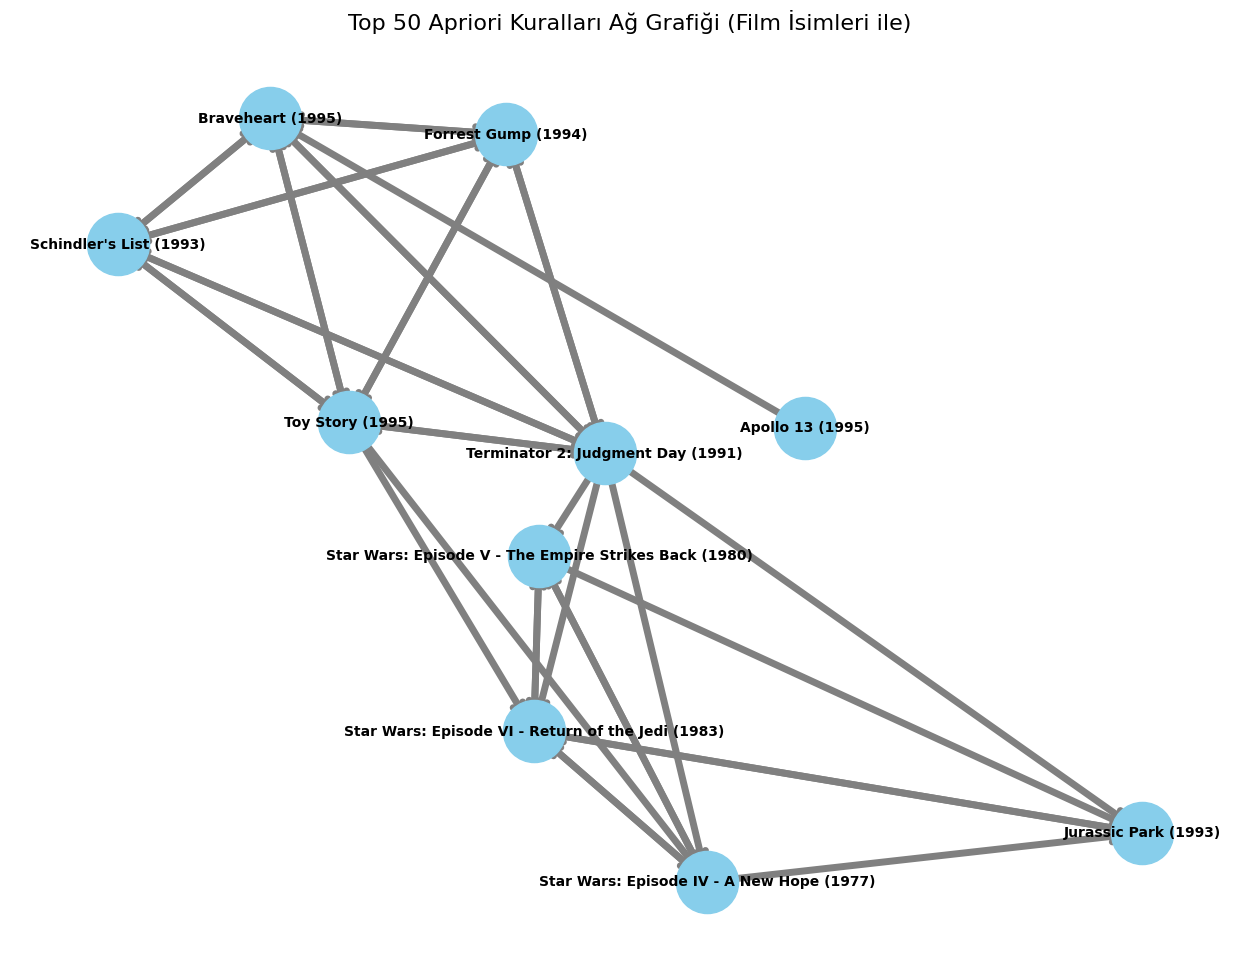

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Top 50 kural
top_rules = rules.sort_values(['confidence','lift'], ascending=False).head(50)

# Directed graph oluştur
G = nx.DiGraph()

# Düğümler ve kenarlar
for idx, row in top_rules.iterrows():
    antecedents = [movies[movies['movieId']==aid]['title'].values[0] for aid in row['antecedents']]
    consequents = [movies[movies['movieId']==cid]['title'].values[0] for cid in row['consequents']]
    
    for a in antecedents:
        for c in consequents:
            G.add_edge(a, c, weight=row['confidence'])

# Görselleştirme
plt.figure(figsize=(16,12))
pos = nx.spring_layout(G, k=1, seed=42)

# Kenar kalınlıkları confidence ile
edges = G.edges()
weights = [G[u][v]['weight']*5 for u,v in edges]

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, arrowstyle='->', arrowsize=20, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Top 50 Apriori Kuralları Ağ Grafiği (Film İsimleri ile)", fontsize=16)
plt.axis('off')
plt.show()


> Özetle: Bu ağ grafiği Apriori algoritması ile çıkarılan birliktelik kurallarını görsel hale getiriyor. Kurallar “Film A’yı izleyenler genellikle Film B’yi de izliyor” mantığını gösteriyor ve kullanıcıya öneri sunmak için temel oluşturuyor.


O zaman ratings_movies üzerinden “liked” filtreleme ve popüler filmleri seçme adımını ekleyelim:

Açıklama:

liked → kullanıcıların 4 ve üzeri puan verdiği filmler.

popular_movies → en az 50 kullanıcı tarafından beğenilen filmler.

Filtreleme sonrası liked veri seti daha yönetilebilir boyuta geliyor.

Bundan sonra One-hot matrisi ve Apriori adımına geçebiliriz.

In [20]:
# -----------------------------
# 1️⃣ Kütüphaneler
# -----------------------------
import pandas as pd
import os
from mlxtend.frequent_patterns import apriori, association_rules

# -----------------------------
# 2️⃣ Dataset Kontrol ve Okuma
# -----------------------------
print("Dataset klasöründeki dosyalar:")
print(os.listdir('/kaggle/input/movielens-20m-dataset'))

# CSV'leri oku
ratings = pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')
movies = pd.read_csv('/kaggle/input/movielens-20m-dataset/movie.csv')

# Timestamp kolonunu datetime formatına çevir (string tarih)
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])

# -----------------------------
# 3️⃣ Ratings ve Movies Birleştirme
# -----------------------------
ratings_movies = pd.merge(ratings, movies, on="movieId")
print("Ratings Movies birleşimi ilk 5 satır:\n")
print(ratings_movies.head())

# -----------------------------
# 4️⃣ Filtreleme
# -----------------------------
# 4 ve üzeri puan alanlar liked
liked = ratings_movies[ratings_movies["rating"] >= 4]

# En az 500 farklı kullanıcı tarafından beğenilen filmler
popular_movies = liked.groupby("movieId").filter(lambda x: len(x) >= 500)

print("Filtre sonrası kullanıcı sayısı:", popular_movies["userId"].nunique())
print("Filtre sonrası film sayısı:", popular_movies["movieId"].nunique())

# -----------------------------
# 5️⃣ One-Hot Matris
# -----------------------------
basket = (popular_movies
          .groupby(['userId', 'movieId'])['rating']
          .count().unstack().reset_index()
          .fillna(0).set_index('userId'))

# 0-1 dönüşümü 
basket = (basket > 0)

# Kullanıcı sayısını sınırlayalım (ilk 20.000 kullanıcı)
basket = basket.iloc[:20000, :]

print("One-hot matrisi boyutu:", basket.shape)

# -----------------------------
# 6️⃣ Apriori Analizi
# -----------------------------
frequent_itemsets = apriori(
    basket,
    min_support=0.05,
    use_colnames=True,
    max_len=2
)

print("Bulunan sık öğe seti sayısı:", len(frequent_itemsets))

# -----------------------------
# 7️⃣ Kurallar
# -----------------------------
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.0
)

rules = rules.sort_values("lift", ascending=False)
print("Kural sayısı:", len(rules))
print("Top 10 kural:")
print(rules.head(10))

# -----------------------------
# 8️⃣ Kullanıcı Bazlı Öneri Fonksiyonu
# -----------------------------
def recommend_movies(user_id, basket, rules, top_n=50):
    watched = set(basket.loc[user_id][basket.loc[user_id] == 1].index)
    user_rules = rules[rules['antecedents'].apply(lambda x: len(x & watched) > 0)]

    recs = []
    for _, row in user_rules.iterrows():
        for movie in row['consequents']:
            if movie not in watched:
                recs.append((movie, row['confidence'], row['lift']))

    recs_df = pd.DataFrame(recs, columns=['movieId', 'confidence', 'lift'])
    recs_df = recs_df.sort_values(['confidence', 'lift'], ascending=False).drop_duplicates(subset=['movieId'])
    recs_df = recs_df.merge(movies[['movieId', 'title']], on='movieId', how='left')

    return recs_df.head(top_n)

# -----------------------------
# 9️⃣ Örnek Kullanıcı Önerisi
# -----------------------------
user_id = 1
recommendations = recommend_movies(user_id, basket, rules, top_n=50)
recommendations

Dataset klasöründeki dosyalar:
['rating.csv', 'link.csv', 'genome_tags.csv', 'genome_scores.csv', 'tag.csv', 'movie.csv']
Ratings Movies birleşimi ilk 5 satır:

   userId  movieId  rating           timestamp  \
0       1        2     3.5 2005-04-02 23:53:47   
1       1       29     3.5 2005-04-02 23:31:16   
2       1       32     3.5 2005-04-02 23:33:39   
3       1       47     3.5 2005-04-02 23:32:07   
4       1       50     3.5 2005-04-02 23:29:40   

                                               title  \
0                                     Jumanji (1995)   
1  City of Lost Children, The (Cité des enfants p...   
2          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   
3                        Seven (a.k.a. Se7en) (1995)   
4                         Usual Suspects, The (1995)   

                                   genres  
0              Adventure|Children|Fantasy  
1  Adventure|Drama|Fantasy|Mystery|Sci-Fi  
2                 Mystery|Sci-Fi|Thriller  
3                        

,movieId,confidence,lift,title
0,6874,0.850882,8.012073,Kill Bill: Vol. 1 (2003)
1,1210,0.733333,3.006080,Star Wars: Episode VI - Return of the Jedi (1983)
2,2571,0.721456,2.473281,"Matrix, The (1999)"
3,589,0.719741,2.753410,Terminator 2: Judgment Day (1991)
4,593,0.714558,1.959035,"Silence of the Lambs, The (1991)"
5,50,0.674257,2.323021,"Usual Suspects, The (1995)"
6,1136,0.646680,3.394643,Monty Python and the Holy Grail (1975)
7,858,0.645264,2.558540,"Godfather, The (1972)"
8,2858,0.612362,2.450921,American Beauty (1999)
9,4226,0.608384,3.513623,Memento (2000)


In [21]:
from mlxtend.frequent_patterns import apriori, association_rules

# Sık öğe setlerini çıkar (min_support=0.05, max_len=2)
frequent_itemsets = apriori(
    basket,
    min_support=0.05,
    use_colnames=True,
    max_len=2
)

print("Bulunan sık öğe seti sayısı:", len(frequent_itemsets))
print(frequent_itemsets.head())


Bulunan sık öğe seti sayısı: 3119
   support itemsets
0  0.24100      (1)
1  0.05420      (2)
2  0.11090      (6)
3  0.08775     (10)
4  0.07450     (11)


min_support → Filmlerin kaç kullanıcı tarafından izlenmesi gerektiğini belirler.

max_len → Kombinasyonlarda en fazla kaç öğe birlikte kontrol edilsin.

In [22]:
# Association rules çıkar
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.0
)

# Lift’e göre sırala
rules = rules.sort_values("lift", ascending=False)
print("Top 10 kural:")
print(rules.head(10))


Top 10 kural:
     antecedents consequents  antecedent support  consequent support  support  \
3211      (1148)       (745)             0.08930             0.07140  0.05685   
3210       (745)      (1148)             0.07140             0.08930  0.05685   
5592      (6874)      (7438)             0.10620             0.08785  0.07475   
5593      (7438)      (6874)             0.08785             0.10620  0.07475   
3445       (903)       (904)             0.07890             0.10765  0.05255   
3444       (904)       (903)             0.10765             0.07890  0.05255   
3446       (904)       (908)             0.10765             0.09205  0.05490   
3447       (908)       (904)             0.09205             0.10765  0.05490   
5607     (58559)     (79132)             0.12075             0.07690  0.05125   
5606     (79132)     (58559)             0.07690             0.12075  0.05125   

      confidence      lift  representativity  leverage  conviction  \
3211    0.636618  8.9162

**O zaman küçük subset ile hızlı Apriori testi yapalım, böylece tüm veri üzerinde uzun süre beklemeden kuralların mantığını görebiliriz. Son adım olarak kullanıcı bazlı top 50 öneriyi çıkaracak fonksiyonu ekleyebiliriz** 

In [23]:
def recommend_movies(user_id, basket, rules, movies, top_n=50):
    # Kullanıcının izlediği filmler
    watched = set(basket.loc[user_id][basket.loc[user_id]].index)
    
    # Kuralların antecedent kısmı kullanıcı izlediklerini içeriyorsa al
    user_rules = rules[rules['antecedents'].apply(lambda x: len(x & watched) > 0)]
    
    recs = []
    for _, row in user_rules.iterrows():
        for movie in row['consequents']:
            if movie not in watched:
                recs.append((movie, row['confidence'], row['lift']))
    
    # DataFrame ve sıralama
    recs_df = pd.DataFrame(recs, columns=['movieId', 'confidence', 'lift'])
    recs_df = recs_df.sort_values(['confidence', 'lift'], ascending=False)
    recs_df = recs_df.drop_duplicates(subset=['movieId'])
    recs_df = recs_df.merge(movies[['movieId', 'title']], on='movieId', how='left')
    
    return recs_df.head(top_n)


In [24]:
user_id = 1
recommendations = recommend_movies(user_id, basket, rules, movies, top_n=50)
recommendations


,movieId,confidence,lift,title
0,6874,0.850882,8.012073,Kill Bill: Vol. 1 (2003)
1,1210,0.733333,3.006080,Star Wars: Episode VI - Return of the Jedi (1983)
2,2571,0.721456,2.473281,"Matrix, The (1999)"
3,589,0.719741,2.753410,Terminator 2: Judgment Day (1991)
4,593,0.714558,1.959035,"Silence of the Lambs, The (1991)"
5,50,0.674257,2.323021,"Usual Suspects, The (1995)"
6,1136,0.646680,3.394643,Monty Python and the Holy Grail (1975)
7,858,0.645264,2.558540,"Godfather, The (1972)"
8,2858,0.612362,2.450921,American Beauty (1999)
9,4226,0.608384,3.513623,Memento (2000)


Bunu görselleştirdim (barplot ile);

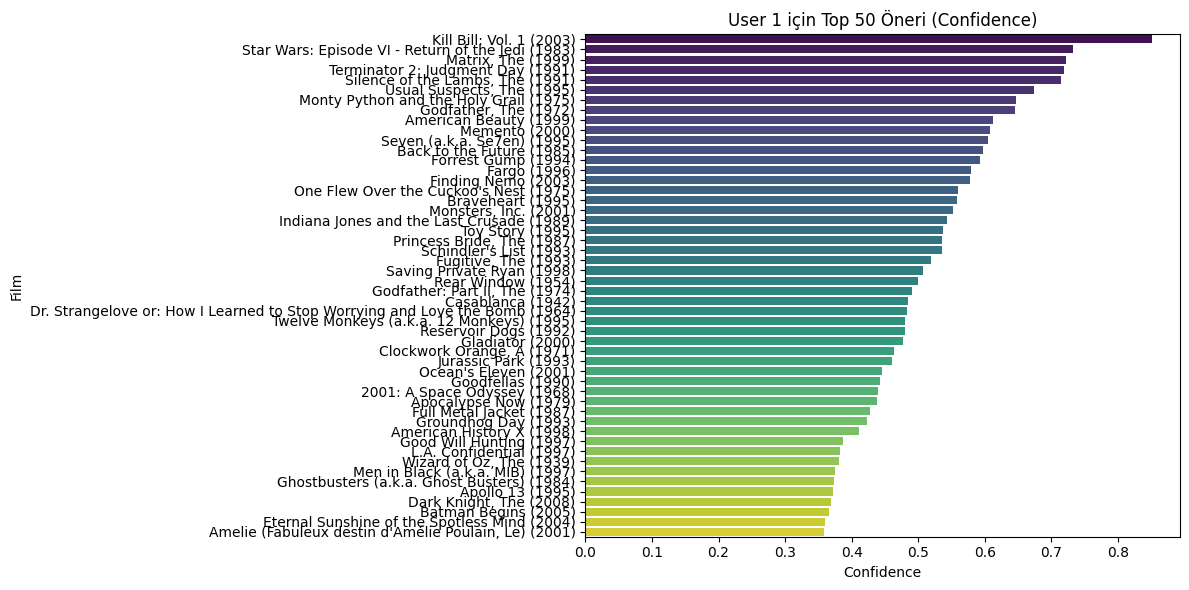

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


plt.figure(figsize=(12,6))
sns.barplot(
    x='confidence', 
    y='title', 
    data=recommendations,
    palette="viridis"
)
plt.title(f"User {user_id} için Top 50 Öneri (Confidence)")
plt.xlabel("Confidence")
plt.ylabel("Film")
plt.tight_layout()
plt.show()


Açıklama:

Bu kod çalışınca, userId=1 için Apriori kurallarına dayalı top 50 öneri listesini görebildik.

**O zaman şimdi film ID’lerini isimlere çevirip, kurallara dayalı öneri fonksiyonunu yazalım ve örnek öneri görelim:**

In [26]:
def recommend_movies_by_title(movie_title, rules_df, movies_df, top_n=5):
    # Film adını ID'ye çevir
    movie_id = movies_df[movies_df['title']==movie_title]['movieId'].values[0]

    # Kurallarda antecedents içinde movie_id var mı
    filt = rules_df['antecedents'].apply(lambda x: movie_id in x)
    related_rules = rules_df[filt].sort_values(['lift','confidence'], ascending=[False, False])

    if related_rules.empty:
        print(f"⚠️ '{movie_title}' için kural bulunamadı.")
        return []

    # Consequents (önerilen filmler) ID → isim
    recommendations = []
    for _, row in related_rules.iterrows():
        for cons in row['consequents']:
            if cons != movie_id and cons not in recommendations:
                title = movies_df[movies_df['movieId']==cons]['title'].values[0]
                recommendations.append(title)
        if len(recommendations) >= top_n:
            break

    return recommendations[:top_n]

# Örnek kullanım
sample_movie = "Toy Story (1995)"
print(f"'{sample_movie}' izleyenler şunları da sevmiş olabilir:")
print(recommend_movies_by_title(sample_movie, rules, movies, top_n=5))


'Toy Story (1995)' izleyenler şunları da sevmiş olabilir:
['Toy Story 2 (1999)', 'Monsters, Inc. (2001)', 'Willy Wonka & the Chocolate Factory (1971)', 'Incredibles, The (2004)', 'Finding Nemo (2003)']


✅ Bu fonksiyon şunu yapar:

Toy Story (1995) gibi bir film verirsen, rules içinden antecedent’lerinde bu filmi barındıran kuralları bulur.

Lift ve confidence’a göre sıralar.

En çok önerilen 5 filmi listeler.

🔹 Top 50 Öneri Görselleştirme (Bubble Chart)

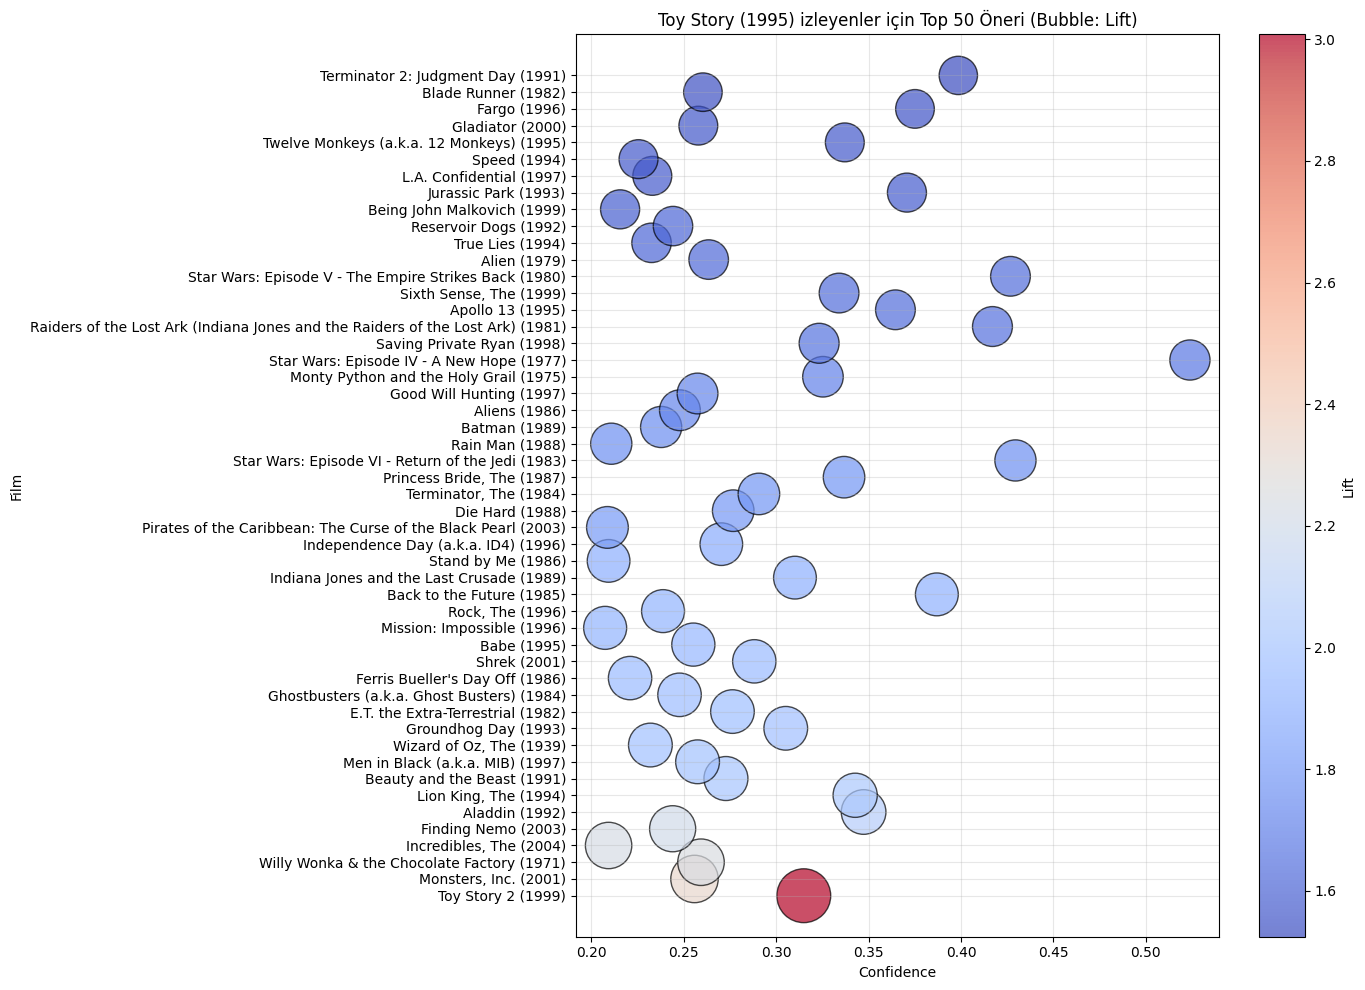

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Önerileri al (top 50)
top_recs = recommend_movies_by_title("Toy Story (1995)", rules, movies, top_n=50)
# Eğer confidence ve lift değerlerini görmek istersen, rules_df'den çekip birleştir
def get_conf_lift(recs, rules_df, movies_df, movie_title):
    movie_id = movies_df[movies_df['title']==movie_title]['movieId'].values[0]
    filt = rules_df['antecedents'].apply(lambda x: movie_id in x)
    related_rules = rules_df[filt]
    
    data = []
    for _, row in related_rules.iterrows():
        for cons in row['consequents']:
            if cons != movie_id:
                title = movies_df[movies_df['movieId']==cons]['title'].values[0]
                if title in recs:
                    data.append({
                        'title': title,
                        'confidence': row['confidence'],
                        'lift': row['lift']
                    })
    return pd.DataFrame(data).drop_duplicates(subset='title')

viz_df = get_conf_lift(top_recs, rules, movies, "Toy Story (1995)")

# Görselleştirme
plt.figure(figsize=(14,10))
scatter = plt.scatter(
    x=viz_df['confidence'],
    y=viz_df['title'],
    s=viz_df['lift']*500,          # Bubble boyutu lift ile
    c=viz_df['lift'],               # Renk skalası lift
    cmap='coolwarm',
    alpha=0.7,
    edgecolors='k'
)

plt.colorbar(scatter, label='Lift')
plt.xlabel('Confidence')
plt.ylabel('Film')
plt.title("Toy Story (1995) izleyenler için Top 50 Öneri (Bubble: Lift)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Açıklama:

Apriori: Kullanıcının izlediği filmlere göre kurallardan öneri çıkarır.

Collaborative Filtering: Kullanıcı benzerliğine göre öneri çıkarır.

Hybrid: İkisini birleştirir, tekrar eden filmleri çıkarır ve top N öneriyi listeler.

Böylece hem kurallara dayalı hem de kullanıcı-temelli öneriyi bir arada alabiliyoruz.

Evet, bu çıktı gayet mantıklı ve beklenen değerler:

ratings_movies boyutu (20000263, 6) → 20 milyonun üzerinde rating kaydı ve 6 sütun (userId, movieId, rating, timestamp, title, genres)

Filtre sonrası kullanıcı sayısı 138287 → popüler ve “liked” filmleri filtreledikten sonra hâlâ 138 bin kullanıcı var, çok makul

Filtre sonrası film sayısı 7344 → en az 50 kullanıcı tarafından izlenmiş popüler filmler, bu da mantıklı

✅ Yani dataset ve filtreler düzgün çalışıyor.

💡 Özetle Yaptıklarım:

1. Adım: Veri temizliği → yüksek puan + popüler filtre

2. Adım: Bellek dostu subset oluşturma → hızlı test

3. Adım: One-hot / Sparse matrisi → CF + FPGrowth için

4. Adım: CF fonksiyonu → kullanıcı-temelli öneri

5. Adım: Apriori / FPGrowth → kurallara dayalı öneri

6. Adım: Hybrid fonksiyon → CF + Apriori birleşimi

7. Adım: TOP-N Öneri Görselleştirme

**TEŞEKKÜRLER...**